#Adversarial Attack
In this section we attemped to test our code againnst adversarial attack to see its performance

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import torch
from torch.utils.data.dataset import Dataset

# Set a manual seed for reproducibility of results
torch.manual_seed(0)

#A custom dataset class to handle the splitting of credit card data into fraud and non-fraud datasets.
class SplitedDataSet(Dataset):

    def __init__(self, mode="non-fraud"):

        CREDIT_CARD_DIRECTORY = '/content/drive/MyDrive/project/creditcard.csv'

        # Load the data from the CSV file
        self.features = []
        self.labels = []
        csvCreditCard = open(CREDIT_CARD_DIRECTORY)
        CreditCardData = csv.reader(csvCreditCard)

        # Define the class to be skipped based on the mode
        if mode == 'non-fraud':
            skipped_class = '1'  # Skip fraudulent transactions
        elif mode == 'fraud':
            skipped_class = '0'  # Skip non-fraudulent transactions

        # Loop through the data and filter based on the mode
        for row in CreditCardData:
            if row[-1] == skipped_class or row[-1] == 'Class':
                continue
            self.features.append(row[:-1])  # Add feature data
            self.labels.append(row[-1])     # Add label data

        # Convert feature and label data from strings to floats
        for i in range(len(self.features)):
            self.features[i] = list(map(float, self.features[i]))
        self.labels = list(map(float, self.labels))

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        assert len(self.features) == len(self.labels), print('data length error')
        return len(self.features)


In [3]:
import torch
from torch.utils.data.dataset import Dataset

class DataSet(Dataset):

    def __init__(self, datasets=[]):

        self.features = []  # Initialize an empty list for features
        self.labels = []    # Initialize an empty list for labels

        # Iterate over each dataset and append its features and labels
        for dataset in datasets:
            # Extract features (excluding the first and last elements) and labels from each dataset
            self.features += [dataset[i][0][1:-1] for i in range(len(dataset))]
            self.labels += [dataset[i][1] for i in range(len(dataset))]

        # Convert the lists of features and labels to torch FloatTensors for processing
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.FloatTensor(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        # Check to ensure that the number of features matches the number of labels
        assert len(self.features) == len(self.labels), print('data length error')
        return len(self.features)


In [4]:
import torch
from torch.utils.data import random_split
import csv
import random

# Set manual seeds for reproducibility of results
torch.manual_seed(4)
random.seed(0)

def getDatasets():

    # Load non-fraudulent and fraudulent data
    non_fraud_Data = SplitedDataSet(mode='non-fraud')
    fraud_Data = SplitedDataSet(mode='fraud')

    # Determine the number of data points for training and testing
    data_point_num = len(non_fraud_Data)
    test_data_point_num = 490  # Number of data points to take out of non fraud data to mix in test dataset
    train_data_point_num = data_point_num - test_data_point_num  # Remaining data points for training

    # Split non-fraudulent data into training and testing subsets
    trainData, nonFraudTestData = random_split(non_fraud_Data, [train_data_point_num, test_data_point_num])

    # Aggregate the training data
    trainData = DataSet([trainData])

    # Split the fraudulent data, taking only 490 data points
    fraud_Data, _ = random_split(fraud_Data, [490, 2])  # Adds upto 492 as there are 492 fraudulant data points

    # Aggregate the testing data (both non-fraudulent and fraudulent)
    testData = DataSet([nonFraudTestData, fraud_Data])

    return trainData, testData


In [5]:
import torch
import torch.nn as nn

# Function for initializing weights in a normal distribution
def weights_init_normal(m):
    classname = m.__class__.__name__
    # Initialize weights for Convolutional layers
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
    # Initialize weights for Linear layers
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)
    # Initialize weights for BatchNorm1d layers
    elif classname.find('BatchNorm1d') != -1:
        nn.init.normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)

# Function to apply weight initialization to the network
def init_weights(net_layer):

    try:
        net_layer.apply(weights_init_normal)
    except:
        raise NotImplementedError('weights initialization error')

# Fully Connected Neural Network (Discriminator)
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        # Define the layers of the FCNN
        self.layer = nn.Sequential(nn.Linear(28, 10),
                                   nn.BatchNorm1d(10),
                                   nn.ReLU(True),
                                   nn.Linear(10, 1))
        # Initialize weights for the layers
        init_weights(self.layer)

    def forward(self, x):
        x = self.layer(x)
        return x

# Autoencoder (Generator)
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(nn.Linear(28, 15),
                                     nn.BatchNorm1d(15),
                                     nn.ReLU(True),
                                     nn.Linear(15, 8),
                                     nn.BatchNorm1d(8),
                                     nn.ReLU(True))
        # Initialize weights for the encoder
        init_weights(self.encoder)

        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(nn.Linear(8, 15),
                                     nn.BatchNorm1d(15),
                                     nn.ReLU(True),
                                     nn.Linear(15, 28))
        # Initialize weights for the decoder
        init_weights(self.decoder)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
import torch
import matplotlib.pyplot as plt

# Function to plot and save the ROC curve along with AUC
def plot_and_save_fig(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', lw = 1, label='AUC = %0.4f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw = 1, linestyle='--')
    plt.legend(loc='lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ion()
    plt.savefig('./fig/AUROC')
    plt.pause(2)
    plt.close()

# Function to calculate the Matthews Correlation Coefficient
def get_MCC(TP, FP, FN, TN):
    try:
        MCC = ( TP * TN - FP * FN) / ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** (1/2)
        MCC = round(MCC, 4)
    except:
        MCC = 0 # Set MCC to 0 in case of a division by zero
    return MCC

# Function to calculate accuracy
def get_accuracy(TP, FP, FN, TN):
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    accuracy = round(accuracy, 4)
    return accuracy

# Function to calculate recall
def get_recall(TP, FP, FN, TN):
    try:
        recall = TP / (TP + FN)
        recall = round(recall, 4)
    except:
        recall = 'N/A' # Return 'N/A' in case of a division by zero
    return recall

# Function to calculate precision
def get_precision(TP, FP, FN, TN):
    try:
        precision = TP / (TP + FP)
        precision = round(precision, 4)
    except:
        precision = 'N/A'  # Return 'N/A' in case of a division by zero
    return precision

# Function to calculate F1 score
def get_F1_score(TP, FP, FN, TN):
    try:
        recall = get_recall(TP = TP, FP = FP, FN = FN, TN = TN)
        precision = get_precision(TP = TP, FP = FP, FN = FN, TN = TN)
        F1_score = 2 / ((1 / recall) + (1 / precision))
        F1_score = round(F1_score, 4)
    except:
        F1_score = 'N/A'  # Return 'N/A' in case of a division by zero
    return F1_score


In [7]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn import metrics
import numpy as np
import random

# Setting training parameters
batch_size = 4096
lr = 2e-4  # Learning rate
n_epochs = 1
normalization = 'z_score'
reconstructionLoss = 'SmoothL1'
mode = 'train'


print(f"Parameters: batch_size={batch_size}, lr={lr}, n_epochs={n_epochs}, normalization={normalization}, reconstructionLoss={reconstructionLoss}, mode={mode}")

# Seed setting for reproducibility
#torch.manual_seed(4)
random.seed(0)

# Loading datasets
print(f'Loading the {mode} dataset...')
trainData, testData = getDatasets()

# Creating data loaders for training and testing
trainDataLoader = DataLoader(dataset=trainData, batch_size=batch_size, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testData, batch_size=batch_size, shuffle=True)
print('Datasets loading finished!')

# Initializing model architectures
print('Building new models...')
generator = autoencoder()  # Generator model (Autoencoder)
discriminator = FCNN()  # Discriminator model (Fully Connected Neural Network)



# Defining optimizers for generator and discriminator
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, weight_decay=1e-4)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, weight_decay=1e-4)
current_epoch = 0

# Setting models to training mode
generator.train()
discriminator.train()

# Setting the reconstruction loss function
reconstructionLoss = nn.SmoothL1Loss()

# Setting adversarial loss functions
BCELoss = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
MSELoss = nn.MSELoss()  # Mean Squared Error Loss

# Initializing loss values and confusion matrix elements
g_loss_Re = 0  # Generator reconstruction loss
g_loss_BCE = 0  # Generator Binary Cross-Entropy loss
d_loss_sum = 0  # Discriminator loss sum
TP, FP, FN, TN = 0, 0, 0, 0  # Elements of the confusion matrix for MCC calculation

sig = nn.Sigmoid()  # Sigmoid activation function


Parameters: batch_size=4096, lr=0.0002, n_epochs=1, normalization=z_score, reconstructionLoss=SmoothL1, mode=train
Loading the train dataset...
Datasets loading finished!
Building new models...


In [8]:
print('start running on train mode...')
for epoch in range(current_epoch, n_epochs):
    print('epoch:', epoch + 1)
    # Resetting loss accumulators for each epoch
    g_loss_Re = 0  # Generator reconstruction loss
    g_loss_BCE = 0 # Generator Binary Cross-Entropy loss
    d_loss_sum = 0 # Discriminator loss sum

    # Iterating over the training dataset
    for i, (features, labels) in enumerate(trainDataLoader):
        labels = labels.unsqueeze(1)  # Adjusting the shape of labels

        # Exception handling to stop training if labels contain any non-zero (fraudulent) data
        if torch.sum(labels) != 0:
            raise Exception('stop')

        # Creating real and fake labels for training
        real_label = torch.ones(labels.size())
        fake_label = torch.zeros(labels.size())

        # Train Generator
        # Generating the reconstruction
        reconstruction = generator(features)
        # Calculating reconstruction loss
        Re_Loss = reconstructionLoss(reconstruction, features)
        # Getting discriminator's prediction on the fake data
        fake_pred = discriminator(reconstruction)
        # Calculating Binary Cross-Entropy loss
        BCE_Loss = BCELoss(fake_pred, real_label)
        # Total generator loss
        g_loss = Re_Loss + BCE_Loss

        # Zeroing out previous gradients
        g_optimizer.zero_grad()
        # Backpropagation
        g_loss.backward()
        # Update generator weights
        g_optimizer.step()

        # Accumulating the losses
        g_loss_Re += torch.sum(Re_Loss)
        g_loss_BCE += torch.sum(Re_Loss)

        # Train Discriminator
        # Getting discriminator's prediction on real data
        real_pred = discriminator(features)
        # Calculating loss on real data
        real_loss = BCELoss(real_pred, real_label)

        # Getting discriminator's prediction on fake data (detached)
        fake_pred = discriminator(reconstruction.detach())
        # Calculating loss on fake data
        fake_loss = BCELoss(fake_pred, fake_label)

        # Total discriminator loss
        d_loss = real_loss + fake_loss

        # Zeroing out previous gradients
        d_optimizer.zero_grad()
        # Backpropagation
        d_loss.backward()
        # Update discriminator weights
        d_optimizer.step()

        # Accumulating the discriminator loss
        d_loss_sum += torch.sum(d_loss)

        # Logging the losses every 10 iterations
        if (i + 1) % 10 == 0:
            print("iteration: {} / {}, Epoch: {} / {}, g_loss_Re: {:.5f}, g_loss_BCE: {:.4f}, d_loss: {:.4f}".format(
                str((i+1)*batch_size), len(trainData), epoch+1, n_epochs, g_loss_Re.data / (500*batch_size), g_loss_BCE.data / (500*batch_size), d_loss_sum.data / (500*batch_size)))
            g_loss_Re = 0
            g_loss_BCE = 0
            d_loss_sum = 0


start running on train mode...
epoch: 1
iteration: 40960 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 81920 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 122880 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 163840 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 204800 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 245760 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000


start running on test mode...
threshold: 0.05
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


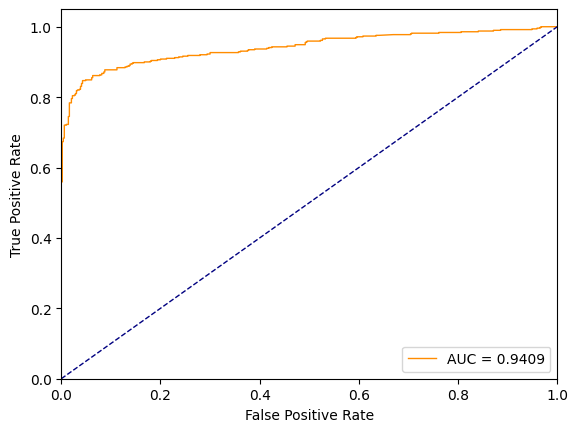

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.1
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


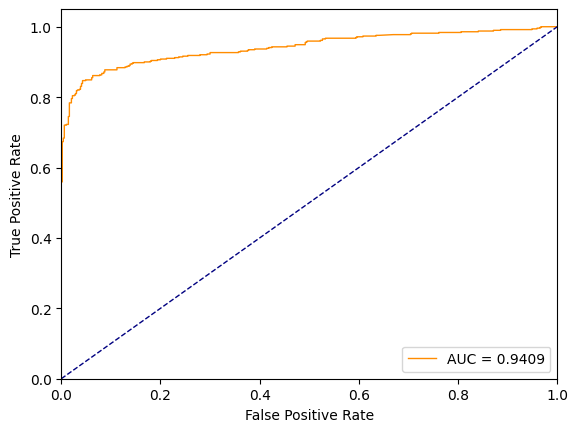

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.15
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


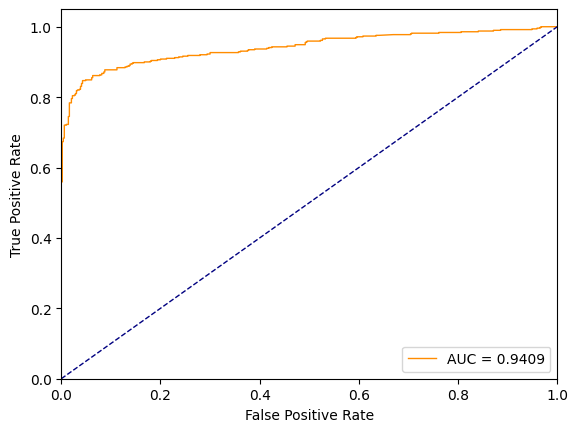

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.2
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


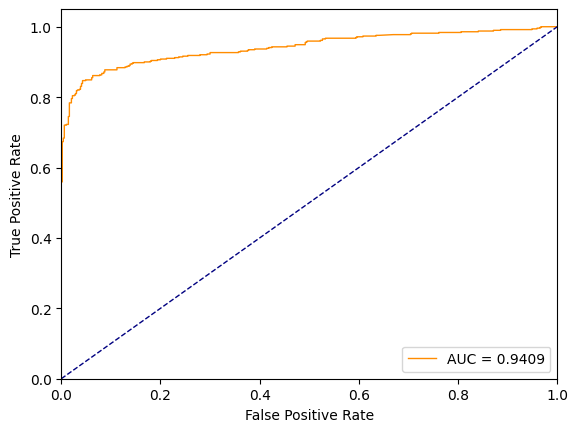

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.25
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


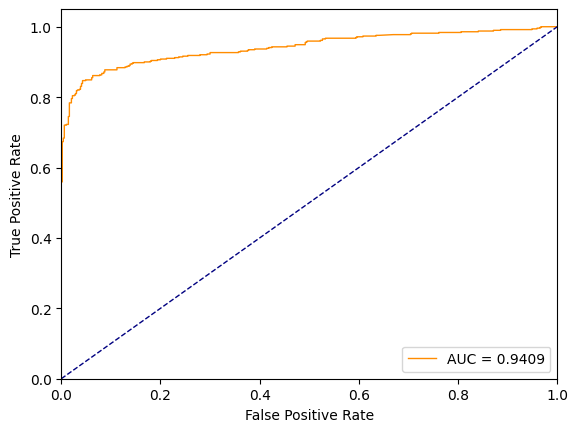

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.3
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


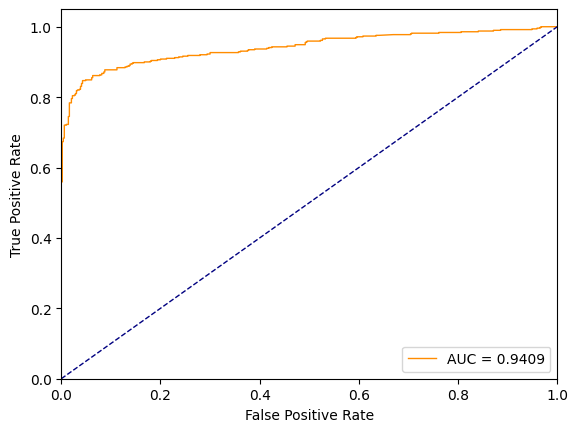

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.35
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


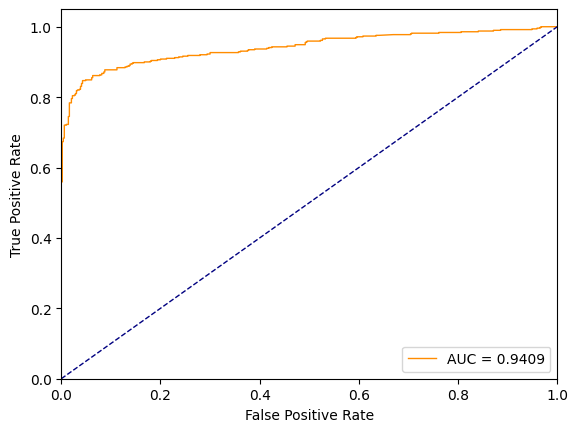

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.4
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


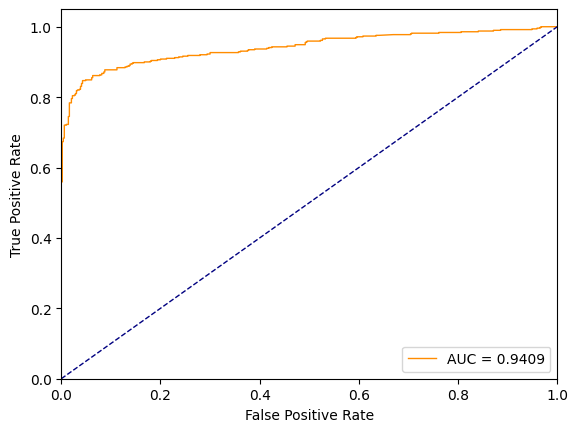

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.45
TP: 490.0
FP: 490.0
TN: 0.0
FN: 0.0


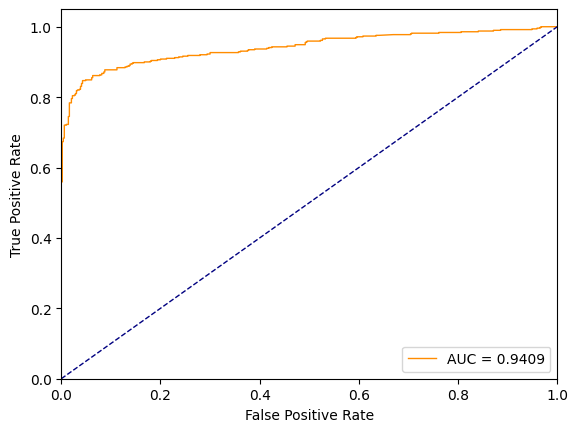

accuracy: 0.5, recall: 1.0, precision: 0.5, F1_score: 0.6667, MCC: 0
threshold: 0.5
TP: 490.0
FP: 477.0
TN: 13.0
FN: 0.0


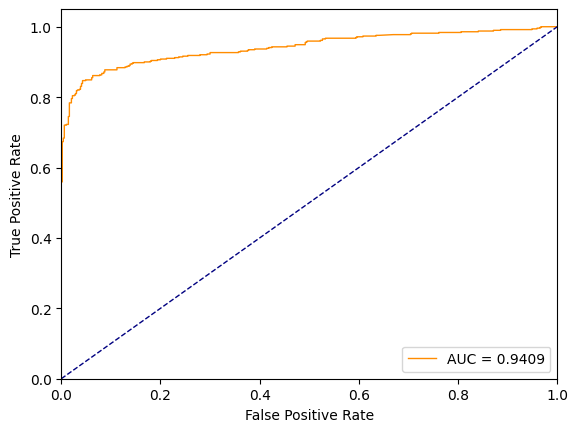

accuracy: 0.5133, recall: 1.0, precision: 0.5067, F1_score: 0.6726, MCC: 0.1159
threshold: 0.55
TP: 470.0
FP: 246.0
TN: 244.0
FN: 20.0


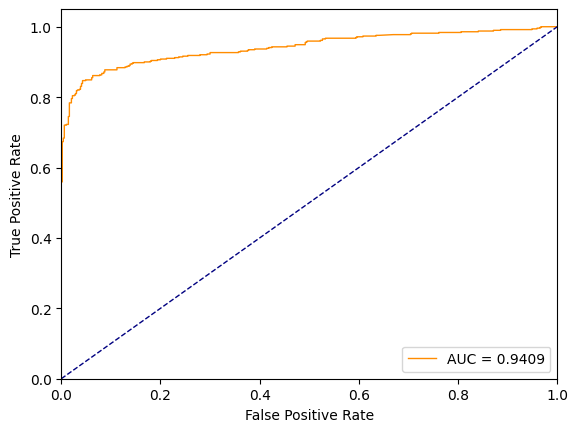

accuracy: 0.7286, recall: 0.9592, precision: 0.6564, F1_score: 0.7794, MCC: 0.5152
threshold: 0.6
TP: 454.0
FP: 152.0
TN: 338.0
FN: 36.0


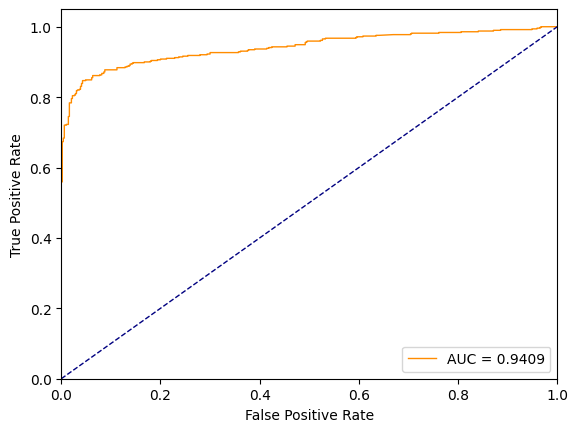

accuracy: 0.8082, recall: 0.9265, precision: 0.7492, F1_score: 0.8285, MCC: 0.6344
threshold: 0.65
TP: 441.0
FP: 82.0
TN: 408.0
FN: 49.0


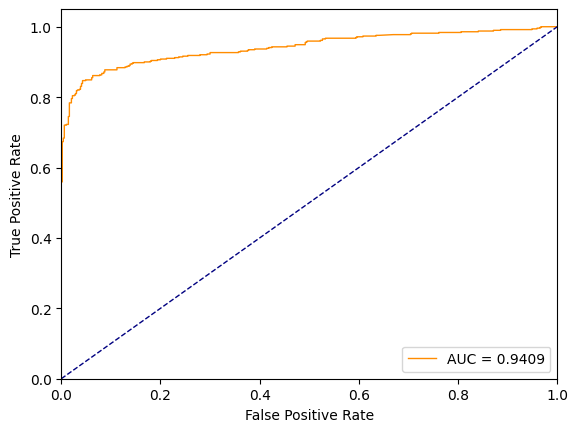

accuracy: 0.8663, recall: 0.9, precision: 0.8432, F1_score: 0.8707, MCC: 0.7343
threshold: 0.7
TP: 430.0
FP: 49.0
TN: 441.0
FN: 60.0


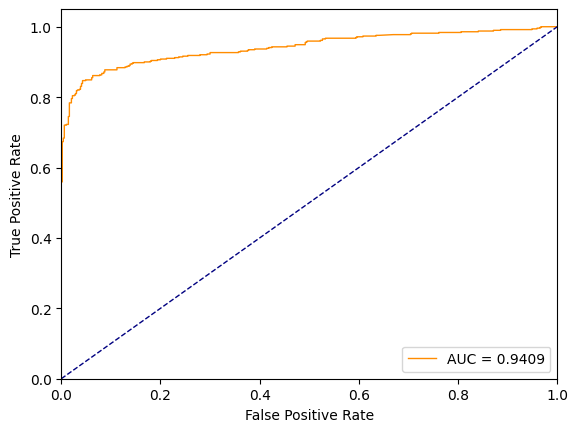

accuracy: 0.8888, recall: 0.8776, precision: 0.8977, F1_score: 0.8875, MCC: 0.7777
threshold: 0.75
TP: 421.0
FP: 31.0
TN: 459.0
FN: 69.0


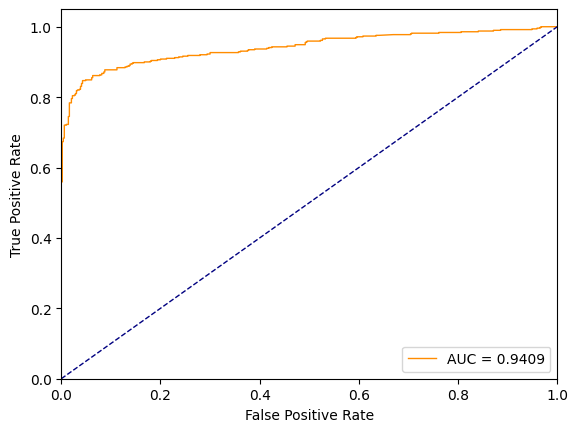

accuracy: 0.898, recall: 0.8592, precision: 0.9314, F1_score: 0.8938, MCC: 0.7983
threshold: 0.8
TP: 409.0
FP: 20.0
TN: 470.0
FN: 81.0


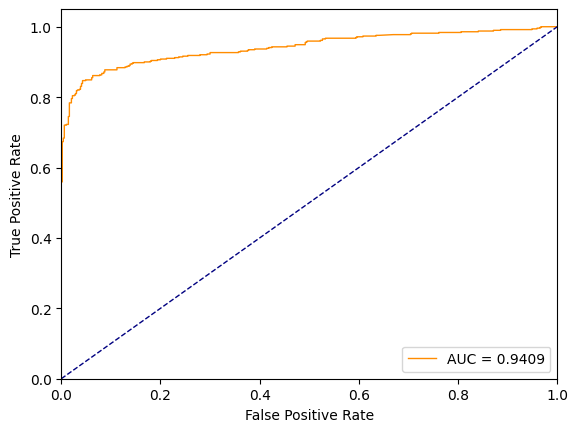

accuracy: 0.8969, recall: 0.8347, precision: 0.9534, F1_score: 0.8901, MCC: 0.8001
threshold: 0.85
TP: 395.0
FP: 13.0
TN: 477.0
FN: 95.0


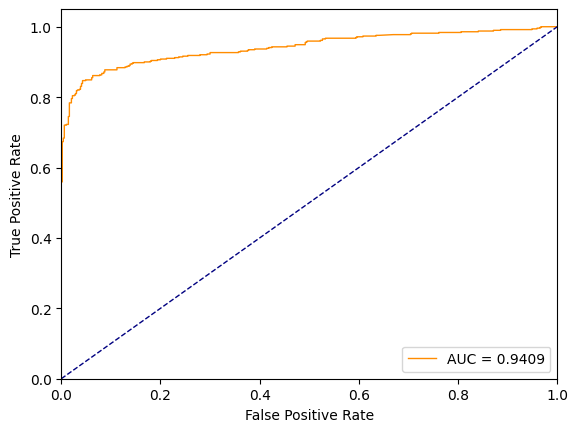

accuracy: 0.8898, recall: 0.8061, precision: 0.9681, F1_score: 0.8797, MCC: 0.7907
threshold: 0.9
TP: 369.0
FP: 8.0
TN: 482.0
FN: 121.0


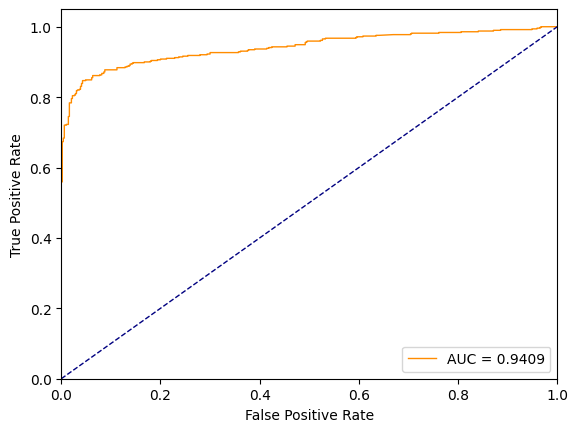

accuracy: 0.8684, recall: 0.7531, precision: 0.9788, F1_score: 0.8512, MCC: 0.7571
threshold: 0.95
TP: 338.0
FP: 3.0
TN: 487.0
FN: 152.0


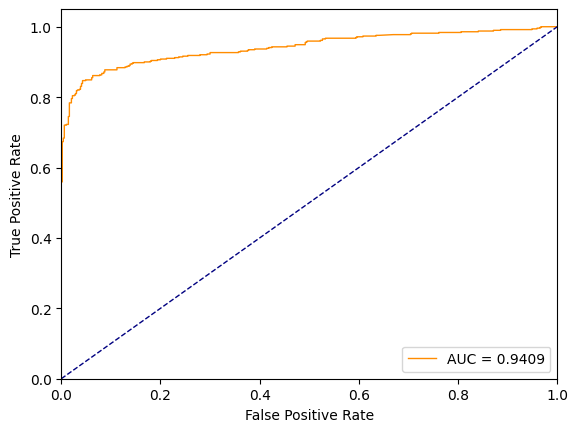

accuracy: 0.8418, recall: 0.6898, precision: 0.9912, F1_score: 0.8135, MCC: 0.7177


In [10]:
# Setting the generator and discriminator to evaluation mode
generator.eval()
discriminator.eval()

print('start running on test mode...')
for i in range(1, 20):
    # Initializing confusion matrix elements
    TP = 0  # True Positives
    FP = 0  # False Positives
    TN = 0  # True Negatives
    FN = 0  # False Negatives
    all_pred = []  # List to store all predictions
    all_labels = []  # List to store all labels
    threshold = i / 20  # Setting threshold for fraud detection
    print('threshold:', threshold)

    # Iterating over the test dataset
    for i, (features, labels) in enumerate(testDataLoader):
        # Test Discriminator
        # Reconstructing the features using the generator
        reconstructed_features = generator(features)
        # Getting probability of fraud from the discriminator
        p_fraud = discriminator(reconstructed_features)
        p_fraud = sig(p_fraud)  # Applying sigmoid activation
        p_fraud = p_fraud.squeeze()
        # Converting predictions to list and appending to all_pred
        all_pred.extend(p_fraud.tolist())
        # Appending labels to all_labels
        all_labels.extend(labels.tolist())

        # Determining final prediction based on threshold
        final_pred = torch.zeros(p_fraud.size())
        final_pred[p_fraud >= threshold] = 1

        # Updating confusion matrix elements
        TP += torch.sum((final_pred == 1) & (labels == 1))
        FP += torch.sum((final_pred == 1) & (labels == 0))
        TN += torch.sum((final_pred == 0) & (labels == 0))
        FN += torch.sum((final_pred == 0) & (labels == 1))

    # Display confusion matrix elements
    print('TP:', float(TP))
    print('FP:', float(FP))
    print('TN:', float(TN))
    print('FN:', float(FN))

    # Calculating and plotting ROC curve and AUC
    fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plot_and_save_fig(fpr, tpr, roc_auc)

    # Calculating performance metrics
    accuracy = get_accuracy(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))
    recall = get_recall(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))
    precision = get_precision(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))
    F1_score = get_F1_score(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))
    MCC = get_MCC(TP=float(TP), FP=float(FP), FN=float(FN), TN=float(TN))

    # Displaying the calculated metrics
    print("accuracy: {}, recall: {}, precision: {}, F1_score: {}, MCC: {}".format(accuracy, recall, precision, F1_score, MCC))


#Adversarial Attack

In [11]:
import torch
import torch.nn.functional as F

def fgsm_attack(dat, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_dat = dat + epsilon * sign_data_grad
    perturbed_dat = torch.clamp(perturbed_dat, 0, 1)
    return perturbed_dat

discriminator.eval()

epsilon = 0.1  # Perturbation amount
loss_function = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss

for features, labels in testDataLoader:
    features.requires_grad = True
    labels = labels.float().unsqueeze(1)  # Ensure labels are floats and have correct shape

    # Forward pass
    outputs = discriminator(features)
    loss = loss_function(outputs, labels)

    # Zero all existing gradients
    discriminator.zero_grad()

    # Backward pass
    loss.backward()

    # Collect data grad
    data_grad = features.grad.data

    # Call FGSM Attack
    perturbed_data = fgsm_attack(features, epsilon, data_grad)

    # Re-evaluate the perturbed data
    output = discriminator(perturbed_data)
    final_pred = (output > 0).float()  # Threshold at zero for binary classification

    # Compare predictions for each instance in the batch
    misclassified = (final_pred != labels).sum().item()
    if misclassified > 0:
        print(f"Adversarial attack successful on {misclassified} instances.")
    else:
        print("Adversarial attack failed.")


Adversarial attack successful on 492 instances.


Adversaial Training

In [12]:
epsilon = 0.2

print('start running on train mode...')
for epoch in range(current_epoch, n_epochs):
    print('epoch:', epoch + 1)
    g_loss_Re =0
    g_loss_BCE =0
    d_loss_sum = 0
    for i, (features, labels) in enumerate(trainDataLoader):
        labels = labels.unsqueeze(1)
        if torch.sum(labels) != 0:
            raise Exception('stop')


        real_label = torch.ones(labels.size())
        fake_label = torch.zeros(labels.size())

        g_optimizer.step()

        g_loss_Re += torch.sum(Re_Loss)
        g_loss_BCE += torch.sum(Re_Loss)

        ##train discriminator
        real_pred = discriminator(features)
        real_loss = BCELoss(real_pred, real_label)

        fake_pred = discriminator(reconstruction.detach())
        fake_loss = BCELoss(fake_pred, fake_label)

        d_loss = real_loss + fake_loss

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        d_loss_sum += torch.sum(d_loss)
        # Generate adversarial examples
        features.requires_grad = True
        outputs = discriminator(features)
        loss = BCELoss(outputs, labels)
        discriminator.zero_grad()
        loss.backward()
        data_grad = features.grad.data
        perturbed_data = fgsm_attack(features, epsilon, data_grad)

        # Retrain discriminator on adversarial examples
        fake_pred_adv = discriminator(perturbed_data)
        loss_adv = BCELoss(fake_pred_adv, labels)
        d_optimizer.zero_grad()
        loss_adv.backward()
        d_optimizer.step()

        if (i + 1) % 10 == 0:
            print("iteration: {} / {}, Epoch: {} / {}, g_loss_Re: {:.5f}, g_loss_BCE: {:.4f}, d_loss: {:.4f}".format(
                str((i+1)*batch_size), len(trainData), epoch+1, n_epochs, g_loss_Re.data / (500*batch_size), g_loss_BCE.data / (500*batch_size), d_loss_sum.data / (500*batch_size)))
            g_loss_Re = 0
            g_loss_BCE = 0
            d_loss_sum = 0
            #print('real_pred:', real_pred)
            #print('fake_pred:', fake_pred)

start running on train mode...
epoch: 1
iteration: 40960 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 81920 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 122880 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 163840 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 204800 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000
iteration: 245760 / 283825, Epoch: 1 / 1, g_loss_Re: 0.00000, g_loss_BCE: 0.0000, d_loss: 0.0000


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn import metrics

generator.eval()
discriminator.eval()

# List of epsilon values to test
epsilon_values = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
sig = nn.Sigmoid()  # Assuming you have defined this earlier

print('Start running on test mode...')
for epsilon in epsilon_values:
    print(f'\nTesting with Epsilon: {epsilon}')
    TP, FP, TN, FN = 0, 0, 0, 0
    all_pred = []
    all_labels = []

    for i, (features, labels) in enumerate(testDataLoader):
        #labels = labels.unsqueeze(1)
        # Generate adversarial examples
        features.requires_grad = True
        outputs = discriminator(features).squeeze(1)
        #outputs = outputs # Squeeze the outputs to match label dimensions
        loss = BCELoss(outputs, labels)
        discriminator.zero_grad()
        loss.backward()
        data_grad = features.grad.data
        perturbed_data = fgsm_attack(features, epsilon, data_grad)

        # Evaluate the discriminator on adversarial examples
        adv_outputs = discriminator(perturbed_data).squeeze(1)
        adv_pred = (adv_outputs > 0).float()

        # Update confusion matrix for adversarial data
        TP += ((adv_pred == 1) & (labels == 1)).sum().item()
        FP += ((adv_pred == 1) & (labels == 0)).sum().item()
        TN += ((adv_pred == 0) & (labels == 0)).sum().item()
        FN += ((adv_pred == 0) & (labels == 1)).sum().item()

    # Calculate and print metrics for adversarial data
    accuracy = get_accuracy(TP, FP, FN, TN)
    recall = get_recall(TP, FP, FN, TN)
    precision = get_precision(TP, FP, FN, TN)
    F1_score = get_F1_score(TP, FP, FN, TN)
    MCC = get_MCC(TP, FP, FN, TN)
    print(f"Epsilon: {epsilon}\tAccuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1 Score: {F1_score}, MCC: {MCC}")


Start running on test mode...

Testing with Epsilon: 0
Epsilon: 0	Accuracy: 0.4388, Recall: 0.8449, Precision: 0.4662, F1 Score: 0.6009, MCC: -0.2099

Testing with Epsilon: 0.05
Epsilon: 0.05	Accuracy: 0.4276, Recall: 0.8286, Precision: 0.4598, F1 Score: 0.5914, MCC: -0.2426

Testing with Epsilon: 0.1
Epsilon: 0.1	Accuracy: 0.4153, Recall: 0.8204, Precision: 0.4532, F1 Score: 0.5839, MCC: -0.289

Testing with Epsilon: 0.15
Epsilon: 0.15	Accuracy: 0.4112, Recall: 0.8143, Precision: 0.4508, F1 Score: 0.5803, MCC: -0.3

Testing with Epsilon: 0.2
Epsilon: 0.2	Accuracy: 0.4092, Recall: 0.8082, Precision: 0.4495, F1 Score: 0.5777, MCC: -0.3014

Testing with Epsilon: 0.25
Epsilon: 0.25	Accuracy: 0.401, Recall: 0.7939, Precision: 0.4446, F1 Score: 0.57, MCC: -0.32

Testing with Epsilon: 0.3
Epsilon: 0.3	Accuracy: 0.3959, Recall: 0.7878, Precision: 0.4416, F1 Score: 0.566, MCC: -0.3351


Even after training the model for adversarial attacks, the accuracy of the model stays rather low